#**Import libraries**

In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import PIL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Download Dataset from kaggle**

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ttungl/adience-benchmark-gender-and-age-classification

100% 1.38G/1.39G [00:56<00:00, 27.4MB/s]
100% 1.39G/1.39G [00:56<00:00, 26.3MB/s]


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/adience-benchmark-gender-and-age-classification.zip', 'r') as zipObj:
  zipObj.extractall('')

#**Explore_dataset**

In [ ]:
data_parent = '/content/AdienceBenchmarkGenderAndAgeClassification/'
print(os.listdir(data_parent))

['faces', '__MACOSX', 'fold_3_data.txt', 'fold_2_data.txt', 'fold_4_data.txt', 'AdienceBenchmarkGenderAndAgeClassification', 'fold_1_data.txt', 'fold_0_data.txt']


In [ ]:
fold_0 = pd.read_csv(os.path.join(data_parent, 'fold_0_data.txt'), sep='\t')
fold_1 = pd.read_csv(os.path.join(data_parent, 'fold_1_data.txt'),sep='\t')
fold_2 = pd.read_csv(os.path.join(data_parent, 'fold_2_data.txt'),sep='\t')
fold_3 = pd.read_csv(os.path.join(data_parent, 'fold_3_data.txt'),sep='\t')
fold_4 = pd.read_csv(os.path.join(data_parent, 'fold_4_data.txt'),sep='\t')
total_data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
total_data.head()


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [ ]:
print('[+] length of the file:', len(total_data))
print('[+] unique values of Age:')
print(total_data.age.unique())
print('===================================================')
print('[+] Number of None Values in Age:')
print((total_data.age == 'None').sum())
print('[+] unique values of Gender:')
print(total_data.gender.unique())
print('===================================================')

[+] length of the file: 19370
[+] unique values of Age:
['(25, 32)' '(38, 43)' '(4, 6)' '(60, 100)' '(15, 20)' '(48, 53)'
 '(8, 12)' '(0, 2)' 'None' '(38, 48)' '35' '3' '55' '58' '22' '13' '45'
 '36' '23' '(38, 42)' '(8, 23)' '(27, 32)' '57' '56' '2' '29' '34' '42'
 '46' '32']
[+] Number of None Values in Age:
748
[+] unique values of Gender:
['f' 'm' nan 'u']


<Axes: ylabel='age'>

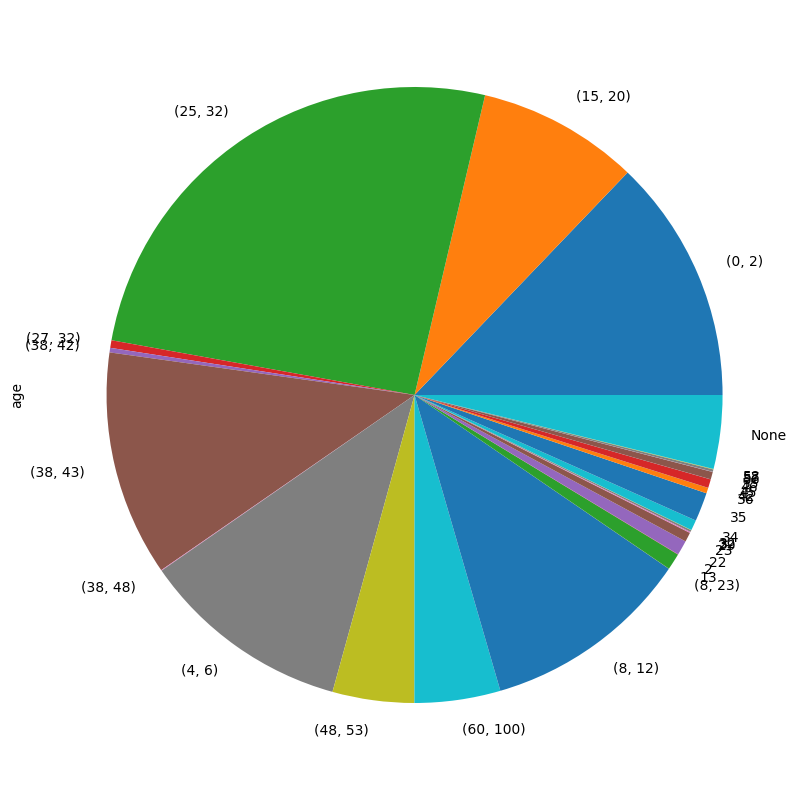

In [ ]:
total_data.groupby('age')['age'].count().plot.pie(figsize=(10, 10))

[+] Image path: /content/AdienceBenchmarkGenderAndAgeClassification/faces/30601258@N03/coarse_tilt_aligned_face.2.11341780544_bd06ba0ee4_o.jpg
[+] Image shape: (600, 601, 3)
[!] Age: (25, 32) Gender: m


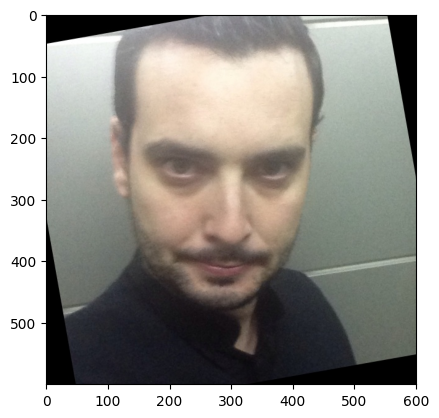

In [ ]:
sample_num = 500
im_name = total_data.iloc[sample_num].original_image
im_path = os.path.join(data_parent, 'faces',str(total_data.iloc[sample_num].user_id), 'coarse_tilt_aligned_face.' + str(total_data.iloc[sample_num].face_id) + '.' + im_name)
print('[+] Image path:', im_path)
image = cv2.imread(im_path)
print('[+] Image shape:', image.shape)
print('[!] Age:', total_data.iloc[sample_num].age)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))



> **Clean data**



In [ ]:
#drop ages with None
df = total_data[total_data.age != 'None'].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18622 entries, 0 to 19345
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             18622 non-null  object
 1   original_image      18622 non-null  object
 2   face_id             18622 non-null  int64 
 3   age                 18622 non-null  object
 4   gender              18551 non-null  object
 5   x                   18622 non-null  int64 
 6   y                   18622 non-null  int64 
 7   dx                  18622 non-null  int64 
 8   dy                  18622 non-null  int64 
 9   tilt_ang            18622 non-null  int64 
 10  fiducial_yaw_angle  18622 non-null  int64 
 11  fiducial_score      18622 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [ ]:
# Mapping Ages to bring All the Ages into there respective Range
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'),
               ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20')
               , ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'),
               ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'),
               ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'),
               ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60-100'), ('57', '60-100'), ('58', '60-100')]
age_mapping_dict = {each[0]: each[1] for each in age_mapping}


In [ ]:
df['age'] = df['age'].apply(lambda age: age_mapping_dict[age])

In [ ]:
print('[+] unique values of Age:')
print(df.age.unique())

[+] unique values of Age:
['25-32' '38-43' '4-6' '60-100' '15-20' '48-53' '8-13' '0-2']


In [ ]:
df['image_path']=data_parent+'faces/' + df['user_id'] + '/coarse_tilt_aligned_face.' + \
        df['face_id'].astype('str') + '.' + df['original_image']


In [ ]:
df.image_path.iloc[0]

'/content/AdienceBenchmarkGenderAndAgeClassification/faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg'




> **Save images on drive**





In [ ]:
%mkdir Aduience_ds

In [ ]:
for idx, path in enumerate(df.image_path): # audience_ds.images.shape[0] = 19370


  image = PIL.Image.open(path)
  age = df.age.iloc[idx]


  # plt.imshow(image)
  # plt.title(f'size (w, h): {image.size}, age: {age}')
  # plt.show()
  image_filename = '/content/Aduience_ds/' + str(age) + '_age_' + str(idx) +'_ID.jpg'
  image.save(image_filename)
  # print(age)
  print(image_filename)
  # if(idx==10):
  #    break


In [ ]:
!zip -r Aduience_ds.zip /content/Aduience_ds

Streaming output truncated to the last 5000 lines.
  adding: content/Aduience_ds/4-6_age_2469_ID.jpg (deflated 2%)
  adding: content/Aduience_ds/25-32_age_15610_ID.jpg (deflated 0%)
  adding: content/Aduience_ds/4-6_age_2848_ID.jpg (deflated 2%)
  adding: content/Aduience_ds/0-2_age_2534_ID.jpg (deflated 1%)
  adding: content/Aduience_ds/38-43_age_10970_ID.jpg (deflated 2%)
  adding: content/Aduience_ds/38-43_age_10787_ID.jpg (deflated 1%)
  adding: content/Aduience_ds/38-43_age_4161_ID.jpg (deflated 2%)
  adding: content/Aduience_ds/38-43_age_17977_ID.jpg (deflated 1%)
  adding: content/Aduience_ds/25-32_age_480_ID.jpg (deflated 1%)
  adding: content/Aduience_ds/4-6_age_17421_ID.jpg (deflated 1%)
  adding: content/Aduience_ds/60-100_age_15714_ID.jpg (deflated 1%)
  adding: content/Aduience_ds/4-6_age_10477_ID.jpg (deflated 1%)
  adding: content/Aduience_ds/4-6_age_12450_ID.jpg (deflated 1%)
  adding: content/Aduience_ds/48-53_age_7456_ID.jpg (deflated 1%)
  adding: content/Aduience_ds

In [ ]:
%cp /content/Aduience_ds.zip /content/drive/MyDrive/Graduation_Projects/Datasets/Audience_DS_Kaggle.zip